---
syncID: 19e0b890b3c64f46b2189c8273a2e0a4
title: "Calculate NDVI & Extract Spectra Using Masks in Python"
description: "Learn to calculate Normalized Difference Vegetation Index (NDVI) and extract spectral using masks with Python." 
dateCreated: 2018-07-05 
authors: Bridget Hass
contributors: Donal O'Leary
estimatedTime: 0.5 hours
packagesLibraries: h5py, gdal, requests
topics: hyperspectral-remote-sensing, HDF5, remote-sensing, 
languagesTool: Python
dataProduct: DP3.30006.001
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/Hyperspectral/intro-hyperspectral/ndvi-spectra-masks/calc_ndvi_extract_spectra.ipynb
tutorialSeries: intro-hsi-py-series
urlTitle: calc-refl-ndvi-py
---

In this tutorial, we will calculate the Normalized Difference Vegetation Index (NDVI) using Python functions.

This tutorial works with the Level 3 <a href="https://data.neonscience.org/data-products/DP3.30006.001" target="_blank">Spectrometer orthorectified surface directional reflectance - mosaic</a> data product. 


<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Calculate NDVI from hyperspectral data in Python.
* Calculate the mean spectra of all pixels whose NDVI is greater than or less than a specified value.

### Install Python Packages

* **requests**
* **pandas**
* **gdal** 
* **h5py**


### Data

Data and additional scripts required for this lesson are downloaded programmatically as part of the tutorial.

The hyperspectral imagery file used in this lesson was collected over the <a href="http://www.neonscience.org/" target="_blank"> National Ecological Observatory Network's </a> <a href="http://www.neonscience.org/field-sites/serc" target="_blank">Smithsonian Environmental Research Center</a> field site in 2021 and processed at NEON headquarters. 

The entire dataset can be accessed on the <a href="http://data.neonscience.org" target="_blank">NEON Data Portal</a>.

</div>


# Calculate NDVI & Extract Spectra with Masks

## Background:
The Normalized Difference Vegetation Index (NDVI) is a standard band-ratio calculation frequently used to analyze ecological remote sensing data. NDVI indicates whether the remotely-sensed target contains live green vegetation. When sunlight strikes objects, certain wavelengths of the electromagnetic spectrum are absorbed and other wavelengths are reflected. The pigment chlorophyll in plant leaves strongly absorbs visible light (with wavelengths in the range of 400-700 nm) for use in photosynthesis. The cell structure of the leaves, however, strongly reflects near-infrared light (wavelengths ranging from 700 - 1100 nm). Plants reflect up to 60% more light in the near infrared portion of the spectrum than they do in the green portion of the spectrum. By calculating the ratio of Near Infrared (NIR) to Visible (VIS) bands in hyperspectral data, we can obtain a metric of vegetation density and health.  

The formula for NDVI is: $$NDVI = \frac{(NIR - VIS)}{(NIR+ VIS)}$$

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-indices/ndvi_tree.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-indices/ndvi_tree.png" width="500"></a>
	<figcaption> NDVI is calculated from the visible and near-infrared light reflected by vegetation. Healthy vegetation (left) absorbs most of the
    visible light that hits it, and reflects a large portion of near-infrared light. Unhealthy or sparse vegetation (right) reflects more
    visible light and less near-infrared light. Source: <a href="https://www.researchgate.net/figure/266947355_fig1_Figure-1-Green-vegetation-left-absorbs-visible-light-and-reflects-near-infrared-light" target="_blank">Figure 1 in Wu et. al. 2014. PLOS. </a>   
	</figcaption>
</figure>

Start by setting plot preferences and loading the neon_aop_hyperspectral.py module:

In [1]:
import os, sys
from copy import copy
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This next function is a handy way to download the Python module and data that we will be using for this lesson. This uses the `requests` package.

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

Download the module from its location on GitHub, add the python_modules to the path and import the neon_aop_hyperspectral.py module as `neon_hs`.

In [4]:
# download the neon_aop_hyperspectral.py module from GitHub
module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_hyperspectral.py"
download_url(module_url,'../python_modules')

# add the python_modules to the path and import the python neon download and hyperspectral functions
sys.path.insert(0, '../python_modules')
# import the neon_aop_hyperspectral module, the semicolon supresses an empty plot from displaying
import neon_aop_hyperspectral as neon_hs;

Define the `data_url` to point to the cloud storage location of the the hyperspectral hdf5 data file

In [ ]:
data_url = "https://storage.googleapis.com/neon-aop-products/2021/FullSite/D02/2021_SERC_5/L3/Spectrometer/Reflectance/NEON_D02_SERC_DP3_368000_4306000_reflectance.h5"

Download the h5 data. You can optionally uncomment the 1st and 3rd lines to display how much time it took to download. This can take a few minutes because it is a fairly large file.

In [ ]:
# start_time = time.time()
download_url(data_url,'.\data')
# print("--- It took %s seconds to download the data ---" % round((time.time() - start_time),1))

### Read in SERC Reflectance Tile

In [7]:
# read the h5 reflectance file (including the full path) to the variable h5_file_name
h5_file_name = data_url.split('/')[-1]
h5_tile = os.path.join(".\data",h5_file_name)
print(f'h5_tile: {h5_tile}')

h5_tile: .\data\NEON_D02_SERC_DP3_368000_4306000_reflectance.h5


In [8]:
serc_refl, serc_refl_md, wavelengths = neon_hs.aop_h5refl2array(h5_tile,'Reflectance')

Reading in  .\data\NEON_D02_SERC_DP3_368000_4306000_reflectance.h5


### Extract NIR and VIS bands

Now that we have uploaded all the required functions, we can calculate NDVI and plot it. 
Below we print the center wavelengths that these bands correspond to:

In [9]:
print('band 58 center wavelength (nm): ', wavelengths[57])
print('band 90 center wavelength (nm) : ', wavelengths[89])

band 58 center wavelength (nm):  669.3261
band 90 center wavelength (nm) :  829.5743


## Calculate & Plot NDVI

Here we see that band 58 represents red visible light, while band 90 is in the NIR portion of the spectrum. Let's extract these two bands from the reflectance array and calculate the ratio using the `numpy.true_divide` which divides arrays element-wise. This also handles a case where the denominator = 0, which would otherwise throw a warning or error.

In [11]:
vis = serc_refl[:,:,57]
nir = serc_refl[:,:,89]

# handle a divide by zero by setting the numpy errstate as follows
with np.errstate(divide='ignore', invalid='ignore'):
    ndvi = np.true_divide((nir-vis),(nir+vis))
    ndvi[ndvi == np.inf] = 0
    ndvi = np.nan_to_num(ndvi)

In [ ]:
Let's take a look at the min, mean, and max values of NDVI that we calculated:

In [13]:
print(f'NDVI Min: {ndvi.min()}')
print(f'NDVI Mean: {round(ndvi.mean(),2)}')
print(f'NDVI Max: {ndvi.max()}')

NDVI Min: -1.0
NDVI Mean: 0.63
NDVI Max: 1.0


We can use the function `plot_aop_refl` to plot this, and choose the `seismic` color pallette to highlight the difference between positive and negative NDVI values. Since this is a normalized index, the values should range from -1 to +1. 

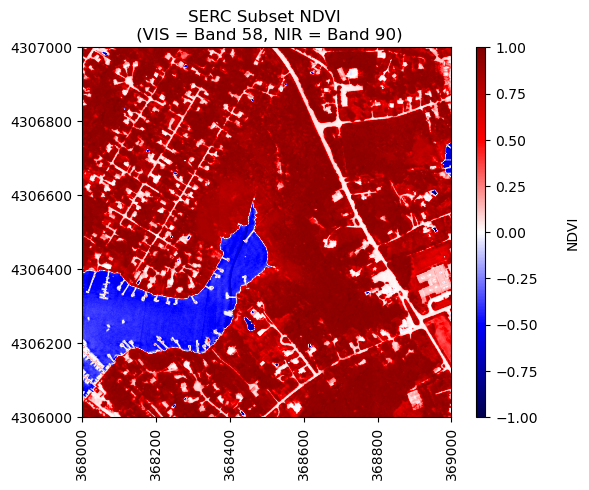

In [14]:
neon_hs.plot_aop_refl(ndvi,serc_refl_md['extent'],
                      colorlimit = (np.min(ndvi),np.max(ndvi)),
                      title='SERC Subset NDVI \n (VIS = Band 58, NIR = Band 90)',
                      cmap_title='NDVI',
                      colormap='seismic')

## Extract Spectra Using Masks

In the second part of this tutorial, we will learn how to extract the average spectra of pixels whose NDVI exceeds a specified threshold value. There are several ways to do this using `numpy`, including the mask functions `numpy.ma`, as well as `numpy.where` and finally using `boolean` indexing. 

To start, lets copy the NDVI calculated above and use booleans to create an array only containing NDVI > 0.6.

In [15]:
# make a copy of ndvi
ndvi_gtpt6 = ndvi.copy()
#set all pixels with NDVI < 0.6 to nan, keeping only values > 0.6
ndvi_gtpt6[ndvi<0.6] = np.nan  
print('Mean NDVI > 0.6:',round(np.nanmean(ndvi_gtpt6),2))

Mean NDVI > 0.6: 0.87


Now let's plot the values of NDVI after masking out values < 0.6.

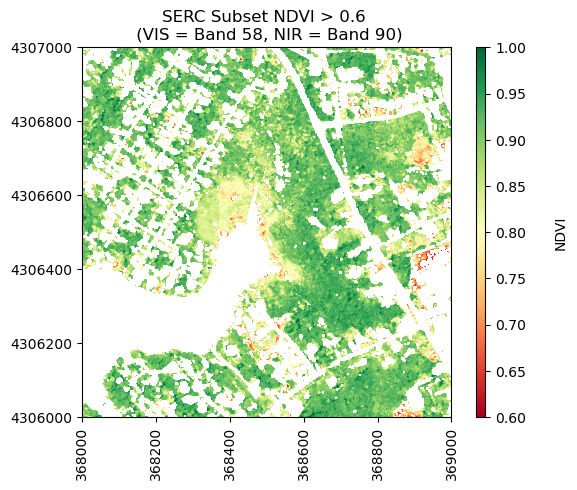

In [16]:
neon_hs.plot_aop_refl(ndvi_gtpt6,
                      serc_refl_md['extent'],
                      colorlimit=(0.6,1),
                      title='SERC Subset NDVI > 0.6 \n (VIS = Band 58, NIR = Band 90)',
                      cmap_title='NDVI',
                      colormap='RdYlGn')

## Calculate the mean spectra, thresholded by NDVI 
Below we will demonstrate how to calculate statistics on arrays where you have applied a mask `numpy.ma`. In this example, the function calculates the mean spectra for values that remain after masking out values by a specified threshold. 

In [18]:
import numpy.ma as ma
def calculate_mean_masked_spectra(refl_array,ndvi,ndvi_threshold,ineq='>'):
    mean_masked_refl = np.zeros(refl_array.shape[2])
    for i in np.arange(refl_array.shape[2]):
        refl_band = refl_array[:,:,i]
        if ineq == '>':
            ndvi_mask = ma.masked_where((ndvi<=ndvi_threshold) | (np.isnan(ndvi)),ndvi)
        elif ineq == '<':
            ndvi_mask = ma.masked_where((ndvi>=ndvi_threshold) | (np.isnan(ndvi)),ndvi)   
        else:
            print('ERROR: Invalid inequality. Enter < or >')
        masked_refl = ma.MaskedArray(refl_band,mask=ndvi_mask.mask)
        mean_masked_refl[i] = ma.mean(masked_refl)
    return mean_masked_refl

We can test out this function for various NDVI thresholds. We'll test two together, and you can try out different values on your own. Let's look at the average spectra for healthy vegetation (NDVI > 0.6), and for a lower threshold (NDVI < 0.3).

In [19]:
serc_ndvi_gtpt6 = calculate_mean_masked_spectra(serc_refl,ndvi,0.6)
serc_ndvi_ltpt3 = calculate_mean_masked_spectra(serc_refl,ndvi,0.3,ineq='<') 

Finally, we can create a `pandas` dataframe to plot the mean spectra.

In [20]:
#Remove water vapor bad band windows & last 10 bands 
w = wavelengths.copy()
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan
w[-10:]=np.nan;  

nan_ind = np.argwhere(np.isnan(w))

serc_ndvi_gtpt6[nan_ind] = np.nan
serc_ndvi_ltpt3[nan_ind] = np.nan

#Create dataframe with masked NDVI mean spectra, scale by the reflectance scale factor
serc_ndvi_df = pd.DataFrame()
serc_ndvi_df['wavelength'] = w
serc_ndvi_df['mean_refl_ndvi_gtpt6'] = serc_ndvi_gtpt6/serc_refl_md['scale_factor']
serc_ndvi_df['mean_refl_ndvi_ltpt3'] = serc_ndvi_ltpt3/serc_refl_md['scale_factor']

Let's take a look at the first 5 values of this new dataframe:

In [21]:
serc_ndvi_df.head()

,wavelength,mean_refl_ndvi_gtpt6,mean_refl_ndvi_ltpt3
0,383.884003,0.055741,0.119835
1,388.891693,0.036432,0.090972
2,393.899506,0.027002,0.076867
3,398.907196,0.022841,0.072207
4,403.915009,0.018748,0.065984


Plot the masked NDVI dataframe to display the mean spectra for NDVI values that exceed 0.6 and that are less than 0.3:

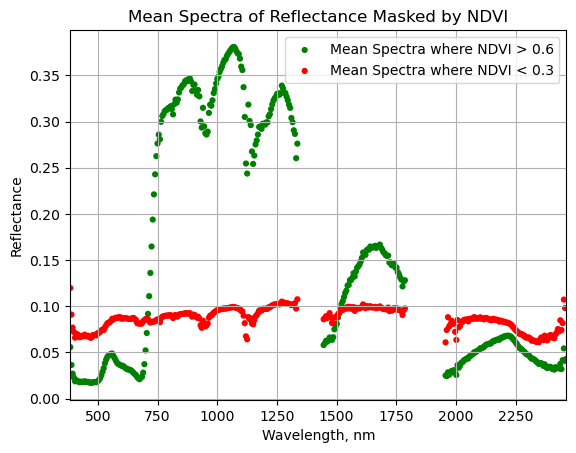

In [23]:
ax = plt.gca();
serc_ndvi_df.plot(ax=ax,x='wavelength',y='mean_refl_ndvi_gtpt6',color='green',
                  edgecolor='none',kind='scatter',label='Mean Spectra where NDVI > 0.6',legend=True);
serc_ndvi_df.plot(ax=ax,x='wavelength',y='mean_refl_ndvi_ltpt3',color='red',
                  edgecolor='none',kind='scatter',label='Mean Spectra where NDVI < 0.3',legend=True);
ax.set_title('Mean Spectra of Reflectance Masked by NDVI')
ax.set_xlim([np.nanmin(w),np.nanmax(w)]);
ax.set_xlabel("Wavelength, nm"); ax.set_ylabel("Reflectance")
ax.grid('on'); 